<a href="https://colab.research.google.com/github/OumaimaFdhila/Clause/blob/master/facenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install facenet-pytorch fastapi uvicorn python-multipart nest-asyncio pyngrok supabase

In [ ]:
# ai
from facenet_pytorch import MTCNN, InceptionResnetV1

# database
from supabase import create_client, Client

# image processing
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image
import numpy as np

# from string to list
import ast

# api
from fastapi import FastAPI, File, UploadFile, HTTPException
from pydantic import BaseModel
from typing import Optional

# decoding
from io import BytesIO
import base64

## Supabase keys and initialisations

In [ ]:
url: str = ""
key: str = ""
supabase: Client = create_client(url, key)

## instenciation mta3 el classes li ne5dmou bihom el face detection

In [ ]:
# ydetecti el blasa mta3 lwejh
mtcnn = MTCNN(image_size=160, margin=0)

# ybadel elwejh vector
resnet = InceptionResnetV1(pretrained='vggface2').eval()

## function ta3teha img wou traja3lek vecteur

In [ ]:
def get_embadding(img):
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  # Get cropped and prewhitened image tensor
  img_cropped = mtcnn(img) #ya3tik elwejh mta3 el image "cropped image"
  # cv2_imshow(img_cropped.permute(1,2,0).numpy() * 255) #n7awlouh l7aja yefhemha cv2

  # Calculate embedding (unsqueeze to add batch dimension)
  img_embedding = resnet(img_cropped.unsqueeze(0))

  boxes, probs, landmarks = mtcnn.detect(img, landmarks=True)

  cv2.rectangle(img,(int(boxes[0][0]),int(boxes[0][1])),(int(boxes[0][2]),int(boxes[0][3])),(255,0,0),3)
  # cv2_imshow(img)

  return img_embedding.squeeze(0)

## function ta3taha 2 vectors mta3 images te7seb el simularity

In [ ]:
def is_same(v1,v2):
  print(np.linalg.norm(v1-v2))
  return np.linalg.norm(v1-v2)<0.9

## classes li ne5dmou bihom wou na3tyouhom lel api

In [ ]:
class User(BaseModel):
    first_name: str
    last_name: str
    image: Optional[str]
    phone_number : str
    email : str
    role : str

class ImageDetection(BaseModel):
    image: Optional[str]

class Euser(BaseModel):
    first_name: str
    last_name: str
    phone_number : str
    email : str
    role : str

## el apis

In [ ]:
app = FastAPI()

@app.get("/")
async def health_check():
    """Health check endpoint."""
    return {"status": "healthy"}

@app.post("/image-detection")
async def get_image_size(data: ImageDetection):
    try:
        if not data.image:
            raise HTTPException(status_code=400, detail="Image is required")

        # Separate the metadata from the base64 data
        header, base64_data = data.image.split(',', 1)

        # Decode the Base64 string to binary data
        image_data = base64.b64decode(base64_data)

        image = Image.open(BytesIO(image_data))
        image = np.array(image)
        response = supabase.table("embaddings").select("embadding , first_name , last_name,id,role").execute()
        embadding = get_embadding(image).detach().numpy()
        for elem in response.data :
          if is_same(np.array(ast.literal_eval(elem["embadding"])),embadding) :
            return {"status": "success", "first_name" : elem["first_name"], "last_name" : elem["last_name"],"id" : elem["id"], "role" : elem["role"] , "found" : True}
        return {"status": "success" , "found" : False}
    except Exception as e:
        print(f"Error: {str(e)}")
        return {"status": "error"}

@app.get("/all_users")
async def get_users():
  try:
        response = supabase.table('embaddings').select("id,first_name,last_name,email,phone_number,role").execute()
        if response.data:
            return {"status": "success","data" : response.data}
        else:
            raise HTTPException(status_code=404, detail="User not found.")
  except Exception as e:
        print(f"Error: {str(e)}")
        return {"status": "error"}


@app.get("/get_user_by_id/{id}")
async def get_user(id: int):
    try:
        if not id:
            raise HTTPException(status_code=400, detail="Id is required")

        print(id)

        response = supabase.table('embaddings').select("first_name,last_name,role,email,phone_number").eq('id', id).execute()

        if response.data:
            return {"status": "success", "data": response.data}
        else:
            raise HTTPException(status_code=404, detail="User not found")
    except Exception as e:
        print(f"Error: {str(e)}")
        raise HTTPException(status_code=500, detail="An error occurred while retrieving the user")


@app.delete("/delete_user/{id}")
async def get_user(id: int):
    try:
        if not id:
            raise HTTPException(status_code=400, detail="Id is required")

        print(id)

        response = supabase.table('embaddings').delete().eq('id', id).execute()

        print(response.data)

        if response.data:
            return {"status": "success"}
        else:
            raise HTTPException(status_code=404, detail="User not found")
    except Exception as e:
        print(f"Error: {str(e)}")
        raise HTTPException(status_code=500, detail="An error occurred while retrieving the user")


@app.put("/edit_user/{id}")
async def edit_user(id: int, user: Euser):
    try:
        if not id:
            raise HTTPException(status_code=400, detail="Id is required")

        # Ensure that the phone number is valid

        if len(user.phone_number) != 8:
            raise HTTPException(status_code=400, detail="Invalid phone number")

        # Update the user in the database

        print(user)
        response = supabase.table('embaddings').update({
            "first_name": user.first_name,
            "last_name": user.last_name,
            "email": user.email,
            "phone_number": user.phone_number,
            "role": user.role
        }).eq('id', id).execute()

        print(response.data)

        if response.data:
            return {"status": "success"}
        else:
            raise HTTPException(status_code=404, detail="User not found")
    except HTTPException as http_err:
        raise http_err
    except Exception as e:
        print(f"Error: {str(e)}")
        raise HTTPException(status_code=500, detail="An error occurred while updating the user")




@app.post("/add_user")
async def add_user(user: User):
    try:
        if not user.image:
            raise HTTPException(status_code=400, detail="Image is required")

        print(user)

        # Separate the metadata from the base64 data
        header, base64_data = user.image.split(',', 1)

        # Decode the Base64 string to binary data
        image_data = base64.b64decode(base64_data)

        # Process the image
        image = Image.open(BytesIO(image_data))
        image_array = np.array(image)

        # Get embeddings
        embedding = get_embadding(image_array).detach().numpy().tolist()

        # Insert data into Supabase
        response = (
            supabase.table("embaddings")
            .insert({
                "first_name": user.first_name,
                "last_name": user.last_name,
                "embadding": embedding,
                "phone_number" : user.phone_number,
                "email": user.email,
                "role" : user.role
            })
            .execute()
        )

        print(response.data)
        return {"status": "success","data" : response.data}
    except Exception as e:
        print(f"Error: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

## ngrok li yrod api accesible lbara mel localhost

INFO:     Started server process [32426]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


Ngrok tunnel established at: https://nearby-prompt-buzzard.ngrok-free.app
13
INFO:     41.229.69.200:0 - "GET /get_user_by_id/13 HTTP/1.1" 200 OK
13
INFO:     41.229.69.200:0 - "GET /get_user_by_id/13 HTTP/1.1" 200 OK
13
INFO:     41.229.69.200:0 - "GET /get_user_by_id/13 HTTP/1.1" 200 OK
13
INFO:     41.229.69.200:0 - "GET /get_user_by_id/13 HTTP/1.1" 200 OK
13
INFO:     41.229.69.200:0 - "GET /get_user_by_id/13 HTTP/1.1" 200 OK
INFO:     41.229.69.200:0 - "GET /all_users HTTP/1.1" 200 OK
INFO:     41.229.69.200:0 - "GET /all_users HTTP/1.1" 200 OK
13
INFO:     41.229.69.200:0 - "GET /get_user_by_id/13 HTTP/1.1" 200 OK
13
INFO:     41.229.69.200:0 - "GET /get_user_by_id/13 HTTP/1.1" 200 OK
13
INFO:     41.229.69.200:0 - "GET /get_user_by_id/13 HTTP/1.1" 200 OK
0.3740341736499598
INFO:     41.229.69.200:0 - "POST /image-detection HTTP/1.1" 200 OK
2
INFO:     41.229.69.200:0 - "GET /get_user_by_id/2 HTTP/1.1" 200 OK
2
INFO:     41.229.69.200:0 - "GET /get_user_by_id/2 HTTP/1.1" 200 OK
I
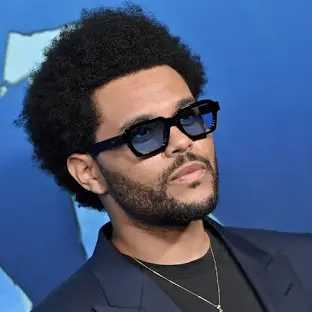

In [ ]:
from pyngrok import ngrok
import nest_asyncio
import uvicorn

token = ""
ngrok.set_auth_token(token)

# Configure ngrok with your custom domain
ngrok_config = {
    'addr': '8000',  # The local port your FastAPI app will run on
    'hostname': '',  # Replace with your actual ngrok domain
    'bind_tls': True  # Enable HTTPS
}

try:
    # Kill any existing tunnels
    ngrok.kill()

    # Start new tunnel with custom domain
    tunnel = ngrok.connect(**ngrok_config)
    print(f'Ngrok tunnel established at: {tunnel.public_url}')
except Exception as e:
    print(f'Error establishing ngrok tunnel: {e}')

nest_asyncio.apply()
# Run the FastAPI app
uvicorn.run(app, port=8000)
